#import libraries

In [1]:
!pip install spectral
import keras
import spectral
from matplotlib import pyplot as plt

import scipy
from scipy.io import loadmat

import sklearn as sk
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from keras.utils import np_utils
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv3D,Conv2D,MaxPooling3D,MaxPooling2D,UpSampling3D,Conv3DTranspose,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K


     |████████████████████████████████| 184kB 8.0MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212955 sha256=f4c1b13a176417e1bbe3d8027d69ccf7b5fa072d9e83b853d36a73807152939e
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


#load dataset

In [2]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat


  
X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print("Load dataset\n")
print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")



--2021-06-03 04:01:52--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   621KB/s    in 9.8s    

2021-06-03 04:02:02 (591 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2021-06-03 04:02:02--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-06-03 04:02:03 (194 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

FINISHED --2021-06-03 04:02:03--
Total wall clock time: 11s
Downloaded: 2

#applying pca

In [3]:
def apply_pca(X,number_of_components = 8):
  
  temp_X = np.reshape(X,(-1,X.shape[2]))
  print(f"temp_X shape : {temp_X.shape}")
  
  pca = PCA(n_components = number_of_components, whiten = True)
  
  pca_X = pca.fit_transform(temp_X[:,:-1])

  new_X = np.reshape(pca_X, (X.shape[0],X.shape[1], number_of_components))
  
  print(f"X shape after applying PCA dimensionality reduction technique : {new_X .shape}")
 
  return new_X, pca


number_of_components = 10

# Passing number of components 20 for PCA to the function apply_pca
X,pca = apply_pca(X,number_of_components)

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 10)


In [4]:
def zero_padding_X(X, margin):

  # Creating a numpy 3D matrix of zeros with the required shape for zero padding
  zero_padded_X = np.zeros((X.shape[0]+2*margin, X.shape[1]+2*margin, X.shape[2]))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  zero_padded_X[offset:X.shape[0]+offset, offset:X.shape[1]+offset,:] = X

  print(f"The shape of X after zero padding : {zero_padded_X.shape}")

  return zero_padded_X 

In [5]:
def zero_padding_y(y, margin):

  # Creating a numpy 2D matrix of zeros with the required shape for zero padding
  zero_padded_y = np.zeros((y.shape[0]+2*margin, y.shape[1]+2*margin))

  # Offset is the starting address of hyperspectral image within zero_padded_y 
  offset = margin 

  zero_padded_y[offset:y.shape[0]+offset, offset:y.shape[1]+offset] = y

  print(f"The shape of y after zero padding : {zero_padded_y.shape}")
  print(np.unique(zero_padded_y))
  return zero_padded_y 

In [6]:
def create_image_cuboids(X, y, window_size=11, remove_class_zero = True, labelling_type = "center"):

  stride = 1
  
  # Calculating the margin required for zero padding for a particular window size (or smaller cube size)
  zero_padding_margin = int((window_size - stride) / 2)
  
  # Applying zero padding to X
  zero_padded_X = zero_padding_X(X, zero_padding_margin)

  # Apply zero padding to y
  zero_padded_y = zero_padding_y(y, zero_padding_margin)

  # Create a 4D matrix of smaller cuboids of zeros 
  X_cuboids = np.zeros((X.shape[0]*X.shape[1], window_size, window_size, X.shape[2]))

  # Create a matrix for assigning labels to smaller cuboids X_cuboids
  y_cuboids_labels = np.zeros((X.shape[0]*X.shape[1]))

  offset = zero_padding_margin

  # Traversing through X and y to split X and y accordingly
  index = 0
  for i in range(offset,zero_padded_X.shape[0]-offset):
    for j in range(offset, zero_padded_X.shape[1]-offset):

        # Extracting smaller cube from zero_padded_X
        cube = zero_padded_X[i-offset:i+offset+1,j-offset:j+offset+1]

        # Storing the extracted cube from zero_padded_X into X_cuboids
        X_cuboids[index,:,:,:] = cube 

        # Storing the extracted matrix from zero_padded_y into y_labels
        y_labels = zero_padded_y[i-offset:i+offset+1,j-offset:j+offset+1]

        if labelling_type=="majority":
          
          # Calculating mode of y_labels matrix
          y_label = mode(y_labels, axis=None, nan_policy="omit")
          
          # Assigning label to a particular index's X_cuboid
          y_cuboids_labels[index] = int(y_label[0])

        elif labelling_type=="center":

          y_label = y_labels[y_labels.shape[0]//2,y_labels.shape[1]//2]
          y_cuboids_labels[index] = int(y_label)

        index+=1   
  print(np.unique(y_cuboids_labels))
  # Removes class zero from X_cuboids and y_cuboids_labels
  if remove_class_zero:
        X_cuboids = X_cuboids[y_cuboids_labels>0,:,:,:]
        y_cuboids_labels = y_cuboids_labels[y_cuboids_labels>0]
        print(np.unique(y_cuboids_labels))
        y_cuboids_labels -= 1 
        print(np.unique(y_cuboids_labels))
  
  print(f"The shape of X_cuboids : {X_cuboids.shape}")
  print(f"The shape of y_cuboids_labels : {y_cuboids_labels.shape}")
 
  return X_cuboids,y_cuboids_labels

window_size=11
X,y = create_image_cuboids(X,y,window_size)

The shape of X after zero padding : (155, 155, 10)
The shape of y after zero padding : (155, 155)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 11, 11, 10)
The shape of y_cuboids_labels : (10249,)


#splitting dataset

In [7]:
def split_data(X, y,test_ratio, random_state = 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state)
    print(f"X_train shape : {X_train.shape}")
    print(f"y_train shape : {y_train.shape}")
    print(f"X_test shape  : {X_test.shape}")
    print(f"y_test shape  : {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

test_ratio = 0.33 

X_train, X_test, y_train, y_test = split_data(X, y, test_ratio)


def count_frequency(y,name):         
    unique, counts = np.unique(y, return_counts=True)
    elements=dict(zip(unique, counts))
    print(f"Number of elements present in each class of {name}: {elements}") 

count_frequency(y_train,name="y_train")    
count_frequency(y_test,name="y_test")


X_train shape : (6866, 11, 11, 10)
y_train shape : (6866,)
X_test shape  : (3383, 11, 11, 10)
y_test shape  : (3383,)
Number of elements present in each class of y_train: {0.0: 36, 1.0: 947, 2.0: 572, 3.0: 166, 4.0: 336, 5.0: 485, 6.0: 21, 7.0: 315, 8.0: 13, 9.0: 633, 10.0: 1634, 11.0: 409, 12.0: 148, 13.0: 846, 14.0: 244, 15.0: 61}
Number of elements present in each class of y_test: {0.0: 10, 1.0: 481, 2.0: 258, 3.0: 71, 4.0: 147, 5.0: 245, 6.0: 7, 7.0: 163, 8.0: 7, 9.0: 339, 10.0: 821, 11.0: 184, 12.0: 57, 13.0: 419, 14.0: 142, 15.0: 32}


#convolution

In [8]:
number_of_components = 10
X_train = X_train.reshape(-1, window_size, window_size, number_of_components , 1)
X_train.shape

y_train = np_utils.to_categorical(y_train)
y_train.shape

(6866, 16)

In [9]:
num_classes=16
S=window_size
L=number_of_components
input_img = Input((S, S, L, 1))
def encoder(input_img):
    #encoder
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1) 
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2) 
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv5) 
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling3D((2,2,2))(conv6) 
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up1) 
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling3D((2,2,2))(conv7) 
    decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out    

In [10]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 10, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 11, 11, 10, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 10, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 11, 10, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 10, 32)    128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 5, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 5, 5, 64)       55360 

In [11]:
encode = encoder(input_img)
autoencoder1 = Model(input_img,fc(encode))
autoencoder1.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 10, 1)]   0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 11, 11, 10, 32)    896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 10, 32)    128       
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 11, 11, 10, 32)    27680     
_________________________________________________________________
batch_normalization_15 (Batc (None, 11, 11, 10, 32)    128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 5, 5, 32)       0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 5, 5, 64)       5536

In [12]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
autoencoder1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [15]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [16]:
history = autoencoder1.fit(X_train, y_train, batch_size=128,epochs=10,callbacks=callbacks_list)

Epoch 1/10
54/54 [==============================] - 3s 56ms/step - loss: 1.1341 - accuracy: 0.6759

Epoch 00001: accuracy improved from -inf to 0.67594, saving model to best-model.hdf5
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.1983 - accuracy: 0.9391

Epoch 00002: accuracy improved from 0.67594 to 0.93912, saving model to best-model.hdf5
Epoch 3/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0665 - accuracy: 0.9812

Epoch 00003: accuracy improved from 0.93912 to 0.98121, saving model to best-model.hdf5
Epoch 4/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0392 - accuracy: 0.9891

Epoch 00004: accuracy improved from 0.98121 to 0.98908, saving model to best-model.hdf5
Epoch 5/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0588 - accuracy: 0.9835

Epoch 00005: accuracy did not improve from 0.98908
Epoch 6/10
54/54 [==============================] - 2s 41ms/step - loss: 0.0195 - accuracy: 0.9948



In [17]:
X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
X_test.shape


(3383, 11, 11, 10, 1)

In [18]:
y_test1 = np_utils.to_categorical(y_test)
y_test1.shape

(3383, 16)

In [19]:

predict_test = autoencoder1.predict(X_test)
pred_test = np.argmax(predict_test, axis=1)
pred_test.shape

classification = classification_report(np.argmax(y_test1, axis=1), pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.98      0.99       481
           2       0.99      0.98      0.99       258
           3       1.00      0.96      0.98        71
           4       0.97      1.00      0.98       147
           5       0.99      1.00      1.00       245
           6       1.00      0.43      0.60         7
           7       1.00      1.00      1.00       163
           8       1.00      1.00      1.00         7
           9       0.94      1.00      0.97       339
          10       0.99      1.00      0.99       821
          11       1.00      0.86      0.93       184
          12       1.00      1.00      1.00        57
          13       1.00      1.00      1.00       419
          14       1.00      0.99      0.99       142
          15       0.86      1.00      0.93        32

    accuracy                           0.99      3383
   macro avg       0.98   

In [20]:
X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print("Load dataset\n")
print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")


Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)





In [21]:
height = y.shape[0]
width = y.shape[1]

In [22]:
X,pca = apply_pca(X, number_of_components)

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 10)


In [23]:
X = zero_padding_X(X, window_size//2)

The shape of X after zero padding : (155, 155, 10)


In [24]:
def Patch(data,height_index,width_index, window_size):
    height_slice = slice(height_index, height_index+window_size)
    width_slice = slice(width_index, width_index+window_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [25]:
from tqdm.auto import trange

outputs = np.zeros((height,width))
for i in trange(height, desc="Building image"):
    for j in trange(width,leave=False):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j,window_size)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (autoencoder1.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

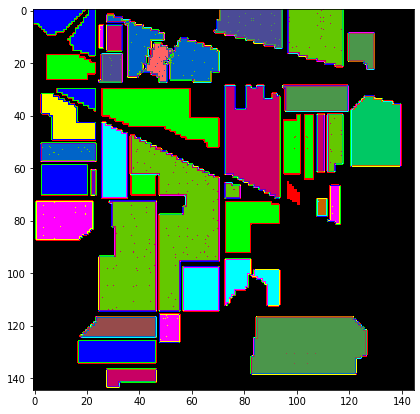

In [26]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

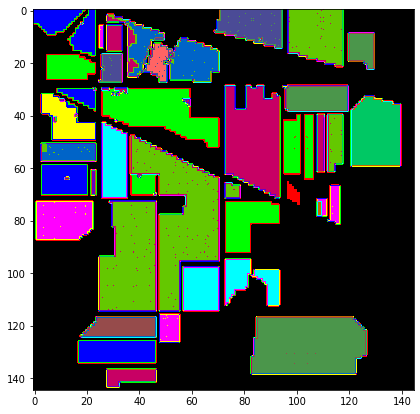

In [27]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))